**2.Visualize the Optimization Process**

In [22]:
torch.manual_seed(1) 
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)  # x data (tensor), shape=(300, 1)
y = (np.sin(5*np.pi*x))/(5*np.pi*x) #non-linear y function
#y = (np.cos(7 * x * np.pi))
print('Xshape:',x.shape,"\n Yshape:",y.shape)

#x, y = Variable(x), Variable(y) #converting data into variables as pytorch requirments
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
n_samples, n_features = x.shape

Xshape: torch.Size([300, 1]) 
 Yshape: torch.Size([300, 1])


<ipython-input-22-faa07d40a19f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [23]:
class M1(nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.fc1 = nn.Linear(1, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        # flatten as one dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
def trainFunc(model,x,y):
    max_epoch = 2500
    epoch_arr,loss_arr=[],[]
    not_converged = True
    epoch = 0
    gradArr = []
    while not_converged:
        epoch += 1
        prediction = model(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #optimizer.step() 
        
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        #Generating Gradient Norm
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        

        optimizer.step() 
        
        gradArr.append(grad_norm)
        
        if epoch%100 == 0 : print(f'epoch: {epoch}, loss = {loss.item():.4f}, grad_norm = {grad_norm}') #, weight = {model.weight.item()},  bias ={model.bias.item()}')
                
        if epoch == max_epoch:
                print("Max Epoch Reached")
                not_converged = False
        elif (epoch > 5) and  (loss_arr[-1] < 0.001):
            if abs(loss_arr[-3] - loss_arr[-2]) < 1.0e-05 and abs(loss_arr[-2] - loss_arr[-1]) < 1.0e-05:
                print("Convergeance reached for loss:",loss_arr[-1])
                not_converged = False
        
        
                
    return epoch_arr,loss_arr,prediction,grad_norm,gradArr

In [25]:
torch.manual_seed(1)
m1 = M1()     # define the network
#optimizer = torch.optim.RMSprop(m1.parameters(), lr=0.0012, weight_decay = 1e-4)
optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

a=[]
for i in m1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)
M1epoch_arr,M1loss_arr,M1prediction,M1grad_norm,M1gradArr = trainFunc(m1,x,y)

Total no of parameters in Model 1: 1501
epoch: 100, loss = 0.0518, grad_norm = 0.042833168430706926
epoch: 200, loss = 0.0310, grad_norm = 0.031609784687791964
epoch: 300, loss = 0.0158, grad_norm = 0.020875737090560575
epoch: 400, loss = 0.0092, grad_norm = 0.012162938301290347
epoch: 500, loss = 0.0066, grad_norm = 0.007910376219090675
epoch: 600, loss = 0.0053, grad_norm = 0.0057546218075202665
epoch: 700, loss = 0.0045, grad_norm = 0.004773614439532592
epoch: 800, loss = 0.0038, grad_norm = 0.00421009314738074
epoch: 900, loss = 0.0032, grad_norm = 0.003963816600963438
epoch: 1000, loss = 0.0027, grad_norm = 0.006400480524769369
epoch: 1100, loss = 0.0023, grad_norm = 0.010663530350307836
epoch: 1200, loss = 0.0020, grad_norm = 0.010301699507119793
epoch: 1300, loss = 0.0017, grad_norm = 0.0045395204436342144
epoch: 1400, loss = 0.0015, grad_norm = 0.0023008825129989057
epoch: 1500, loss = 0.0014, grad_norm = 0.015228323280006536
epoch: 1600, loss = 0.0012, grad_norm = 0.0250349996

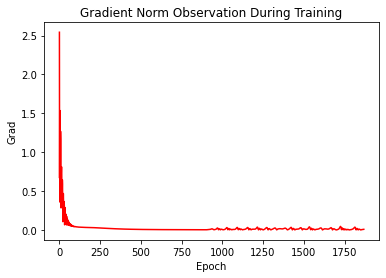

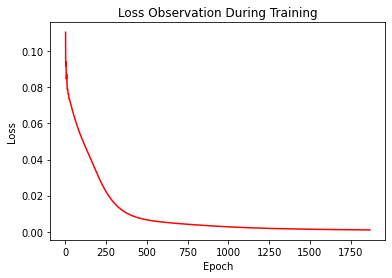

In [28]:
#plot 1
plt.plot(M1epoch_arr,M1gradArr,color="Red")
plt.title('Gradient Norm Observation During Training')
plt.xlabel("Epoch")
plt.ylabel("Grad")
plt.savefig(path+'/GradientNorm.pdf',
            dpi=700,
            bbox_inches='tight')
plt.show()
#plot 2
plt.plot(M1epoch_arr,M1loss_arr,color="Red")
plt.title('Loss Observation During Training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path+'/Loss.pdf',
            dpi=700,
            bbox_inches='tight')
plt.show()

3.What Happened When Gradient is Almost Zero

In [29]:
!pip install autograd_lib
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib
from torch.utils.data import DataLoader, TensorDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 40.2 MB/s eta 0:00:00


In [30]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

In [31]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
    

In [32]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)
    
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues 
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 

    return ratio_mean

In [34]:
def get_norm_minimal_ratio(model,criterion):

    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [35]:
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm


def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        prediction = model(X)
        loss = criterion(prediction, Y)
        loss.backward()
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model,criterion)
        optimizer.step() 
        optimizer.zero_grad()
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
    return history,grad_norm_per_epoch,model

In [36]:
num_of_rows = 300
lr = 0.0004
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2500
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
filename = criterion_name+ optimizer_name+".png"
grad_norm_name = "_grad_norm_name1_2.png"
result_folder_name = "result3/"

In [37]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2000
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
input_size=1
output_size=1
model= MathRegressor()

In [38]:
autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)
           

In [39]:
result_1 = evaluate(model,criterion,data_loader)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [40]:
filename = criterion_name+ optimizer_name+".png"

In [41]:
train,target = X,Y

In [42]:
class M1(torch.nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.hidden1 = torch.nn.Linear(1, 5)   # hidden layer
        self.hidden2 = torch.nn.Linear(5, 10)
        self.hidden3 = torch.nn.Linear (10, 10)
        self.hidden4 = torch.nn.Linear (10, 10)
        self.hidden5 = torch.nn.Linear (10, 10)
        self.hidden6 = torch.nn.Linear (10, 10)
        self.hidden7 = torch.nn.Linear (10,5)
        self.predict = torch.nn.Linear(5, 1)   # output layer
        #self.activation = nn.LeakyReLU()
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))      # activation function for hidden layer
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = F.leaky_relu(self.hidden5(x))
        x = F.leaky_relu(self.hidden6(x))
        x = F.leaky_relu(self.hidden7(x))
        x = self.predict(x)                    # linear output
        return x

model_1 = M1()     # define the network


In [43]:
history_1,grad_norm_1,model  = fit(num_epochs, lr, model, data_loader, criterion,optimizer)

<ipython-input-32-03f6557ee650>:42: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2794.)
  h_eig = torch.symeig(h).eigenvalues


gradient norm: 0.1595542598515749, minimum ratio: 0.6953125
Epoch [0], val_loss: 0.0885
gradient norm: 0.2094506649300456, minimum ratio: 0.72265625
Epoch [1], val_loss: 0.0897
gradient norm: 0.26820208225399256, minimum ratio: 0.71875
Epoch [2], val_loss: 0.0912
gradient norm: 0.33107542991638184, minimum ratio: 0.7109375
Epoch [3], val_loss: 0.0933
gradient norm: 0.3960586152970791, minimum ratio: 0.72265625
Epoch [4], val_loss: 0.0958
gradient norm: 0.4622521437704563, minimum ratio: 0.7265625
Epoch [5], val_loss: 0.0988
gradient norm: 0.5292240530252457, minimum ratio: 0.71875
Epoch [6], val_loss: 0.1023
gradient norm: 0.5967067517340183, minimum ratio: 0.734375
Epoch [7], val_loss: 0.1062
gradient norm: 0.6645790655165911, minimum ratio: 0.73828125
Epoch [8], val_loss: 0.1106
gradient norm: 0.7327027712017298, minimum ratio: 0.7265625
Epoch [9], val_loss: 0.1154
gradient norm: 0.8010115306824446, minimum ratio: 0.74609375
Epoch [10], val_loss: 0.1208
gradient norm: 0.8694694936275

In [44]:
grad_norm_1

{0: {'grad_norm': 0.1595542598515749, 'ratio': 0.6953125},
 1: {'grad_norm': 0.2094506649300456, 'ratio': 0.72265625},
 2: {'grad_norm': 0.26820208225399256, 'ratio': 0.71875},
 3: {'grad_norm': 0.33107542991638184, 'ratio': 0.7109375},
 4: {'grad_norm': 0.3960586152970791, 'ratio': 0.72265625},
 5: {'grad_norm': 0.4622521437704563, 'ratio': 0.7265625},
 6: {'grad_norm': 0.5292240530252457, 'ratio': 0.71875},
 7: {'grad_norm': 0.5967067517340183, 'ratio': 0.734375},
 8: {'grad_norm': 0.6645790655165911, 'ratio': 0.73828125},
 9: {'grad_norm': 0.7327027712017298, 'ratio': 0.7265625},
 10: {'grad_norm': 0.8010115306824446, 'ratio': 0.74609375},
 11: {'grad_norm': 0.8694694936275482, 'ratio': 0.75390625},
 12: {'grad_norm': 0.9380294010043144, 'ratio': 0.7421875},
 13: {'grad_norm': 1.0066642668098211, 'ratio': 0.72265625},
 14: {'grad_norm': 1.0753631498664618, 'ratio': 0.734375},
 15: {'grad_norm': 1.1441313102841377, 'ratio': 0.74609375},
 16: {'grad_norm': 1.2129315882921219, 'ratio':

In [45]:
val_losses_1 = [r['val_loss'] for r in history_1]

In [46]:
len(val_losses_1)

2000

In [47]:
minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]

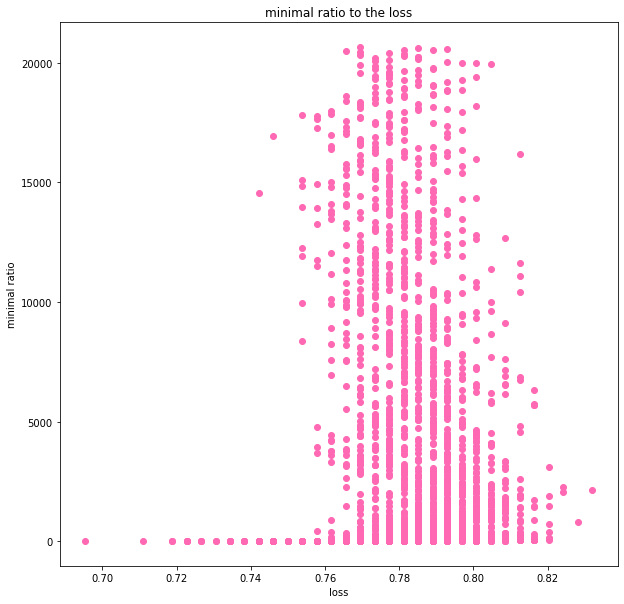

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(minimal_ratio_eps,val_losses_1,color = 'hotpink')
plt.xlabel('loss')
plt.ylabel('minimal ratio')
plt.title('minimal ratio to the loss');
plt.plot()
plt.savefig(path+'/ZeroGrad.pdf',
            dpi=700,
            bbox_inches='tight')
plt.savefig("loss_vs_minimal ratio.png")